In [2]:
import pandas as pd
import seaborn as sns
from ipyleaflet import *
from branca.colormap import linear
import matplotlib.pyplot as plt
import json
import pandas
import folium
import geopandas as gpd
from colour import Color
from pandas_profiling import ProfileReport
import numpy as np
from ipywidgets import *
import sklearn as skl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
# On importe le data frame que l'on a construit (cf note book get_data)

#df_regression = pd.read_csv(r'C:\Users\matth\OneDrive - GENES\ENSAE 2A\Python pour le data scientist/df_regression.csv')
df_regression = pd.read_csv('../df_regression.csv')


#On ne garde que les données à partir de 1995 pour que la régression soit la plus fiable possible
df_regression = df_regression[df_regression['year']>= 1995]

In [4]:
# On recalibre les données pour effectuer une régression, passage du format long au format wide
df_final = pd.DataFrame()
for cntry in df_regression.country.unique():
    df_temp = df_regression[df_regression.country == cntry]
    df_new = pd.DataFrame({cntry:[]})
    columns = np.array(df_temp.columns)
    for y in range(1990,2019):

        if df_temp[df_temp.year == y].empty:

            for col in columns:
                if col != 'year' and col != 'country':
                    filler = df_temp[col].mean()
                    df_new.loc[str(y) + '-' + col] = filler
        else:

            for col in columns:
                if col != 'year' and col != 'country':
                    df_new.loc[str(y) + '-' + col] = df_temp[df_temp.year == y][col].values

    df_final = pd.concat([df_final, df_new.transpose()])
    
df_final

,1990-croissancePIB,1990-mortalite-enf,1990-population,1990-export,1990-polity2,1990-ratio-zone,1990-ratio,1991-croissancePIB,1991-mortalite-enf,1991-population,...,2017-polity2,2017-ratio-zone,2017-ratio,2018-croissancePIB,2018-mortalite-enf,2018-population,2018-export,2018-polity2,2018-ratio-zone,2018-ratio
Zimbabwe,1.268572,20981.083333,1.256234e+07,136.330378,-1.416667,0.000450,0.000000,1.268572,20981.083333,1.256234e+07,...,4.0,0.000030,0.000000,4.824211,17413.0,14438812.0,210.771948,4.0,0.002011,0.000000
Zambia,5.534573,33454.041667,1.268306e+07,494.755586,5.000000,0.006294,0.000008,5.534573,33454.041667,1.268306e+07,...,6.0,0.000293,0.000000,4.034494,26866.0,17351714.0,1012.443792,6.0,0.002291,0.000000
Yemen,1.120798,40852.250000,2.128825e+07,111.755404,-1.166667,0.000316,0.000000,1.120798,40852.250000,2.128825e+07,...,0.0,0.000040,0.000000,0.752447,37517.0,28498683.0,33.288874,0.0,0.000128,0.000000
Vietnam,6.671504,31087.041667,8.523303e+07,500.452668,-7.000000,0.000000,0.000000,6.671504,31087.041667,8.523303e+07,...,-7.0,0.000000,0.000000,7.075789,25987.0,95545959.0,1682.653459,-7.0,0.000000,0.000000
Uzbekistan,5.771034,22790.041667,2.733835e+07,255.060565,-9.000000,0.132058,0.000215,5.771034,22790.041667,2.733835e+07,...,-9.0,0.199614,0.000000,5.354997,11479.0,32956100.0,387.671272,-9.0,0.312684,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Argentina,2.205179,10587.208333,3.954242e+07,180.912015,8.000000,0.003082,0.000000,2.205179,10587.208333,3.954242e+07,...,9.0,0.028273,0.000000,-2.617396,6560.0,44494502.0,234.543108,9.0,0.027312,0.000000
Angola,6.357488,82248.166667,2.124495e+07,381.830277,-2.958333,0.000045,0.006081,6.357488,82248.166667,2.124495e+07,...,-2.0,0.000000,0.000262,-2.003630,64019.0,30809787.0,514.553299,-2.0,0.000000,0.000279
Algeria,3.416667,21136.541667,3.457893e+07,175.686146,0.125000,0.010172,0.014457,3.416667,21136.541667,3.457893e+07,...,2.0,0.019693,0.000777,1.100000,20875.0,42228415.0,189.716555,2.0,0.024777,0.000407
Albania,4.837915,812.416667,2.994021e+06,435.138961,7.375000,0.000000,0.000003,4.837915,812.416667,2.994021e+06,...,9.0,0.000000,0.000000,4.019360,289.0,2866376.0,1097.548787,9.0,0.000000,0.000000


In [5]:
# On va essayer de prédire le ratio de risque de 2018 en utilisant toutes les données antérieures
df_final.rename(columns = {'2018-ratio':'aim'}, inplace = True)
df_final

# On sépare le jeu de données en entrainement / test
train, test = train_test_split(df_final, test_size = 0.2)
X_train = train.iloc[:, :-2]
y_train = train.iloc[:,-1:]
X_test = test.iloc[:, :-2]
y_test = test.iloc[:,-1:]

# On standardise les valeurs passées en entrée
scalerX = StandardScaler().fit(X_train)
scalerX_test = StandardScaler().fit(X_test)

X_strain = scalerX.transform(X_train)
X_stest = scalerX_test.transform(X_test)

In [6]:
# On effectue une régression linéaire utilisant toutes les données depuis 1995 pour prédire la dangerosité du pays en 2018

clf = LinearRegression()
clf.fit(X_strain, y_train.values)

# On regarde les prédictions
X_test['aim'] = y_test
X_test['prediction'] = clf.predict(X_stest)

In [7]:
X_test['country'] = X_test.index.values
X_test

,1990-croissancePIB,1990-mortalite-enf,1990-population,1990-export,1990-polity2,1990-ratio-zone,1990-ratio,1991-croissancePIB,1991-mortalite-enf,1991-population,...,2017-ratio-zone,2017-ratio,2018-croissancePIB,2018-mortalite-enf,2018-population,2018-export,2018-polity2,aim,prediction,country
Fiji,2.494584,3.899167e+02,8.350065e+05,137.033685,1.708333,0.000000,0.000000,2.494584,3.899167e+02,8.350065e+05,...,0.000000,0.000000,3.812351,407.000000,8.834900e+05,177.955556,2.000000,0.000000,-0.031939,Fiji
Sri Lanka,5.207129,4.073417e+03,1.977491e+07,136.860387,4.958333,0.000000,0.040214,5.207129,4.073417e+03,1.977491e+07,...,0.000000,0.000010,3.272000,2144.000000,2.167000e+07,218.954471,6.000000,0.000000,-0.026505,Sri Lanka
Cyprus,3.038233,5.304167e+01,1.042691e+06,185.740559,10.000000,0.000000,0.000000,3.038233,5.304167e+01,1.042691e+06,...,0.000000,0.000000,5.692842,24.000000,1.189262e+06,531.171666,10.000000,0.000000,-0.035573,Cyprus
Liberia,2.677052,1.192204e+04,3.474671e+06,101.193642,3.666667,0.010686,0.010368,2.677052,1.192204e+04,3.474671e+06,...,0.000000,0.000000,1.157575,9930.000000,4.818976e+06,157.130699,7.000000,0.000000,-0.073301,Liberia
Philippines,5.076581,6.038483e+04,8.844496e+07,116.178024,8.000000,0.000000,0.011766,5.076581,6.038483e+04,8.844496e+07,...,0.000000,0.017240,6.341486,48672.000000,1.066514e+08,182.013159,8.000000,0.005069,0.044527,Philippines
Greece,0.893963,4.743750e+02,1.088425e+07,186.579804,10.000000,0.013124,0.000000,0.893963,4.743750e+02,1.088425e+07,...,0.004532,0.000000,1.668429,291.000000,1.073288e+07,337.005653,10.000000,0.000000,0.004724,Greece
Czech Republic,2.798948,3.763333e+02,1.037582e+07,342.063053,9.458333,0.000000,0.000000,2.798948,3.763333e+02,1.037582e+07,...,0.000000,0.000000,3.198656,282.000000,1.062993e+07,695.122897,9.000000,0.000000,0.005275,Czech Republic
Germany,1.431826,2.847042e+03,8.194600e+07,187.392231,10.000000,0.000110,0.000005,1.431826,2.847042e+03,8.194600e+07,...,0.000020,0.000000,1.086025,2512.000000,8.290578e+07,283.503876,10.000000,0.000000,-0.007391,Germany
Sudan,4.694818,6.733188e+04,2.954529e+07,246.812538,-4.882353,0.092022,0.077394,4.694818,6.733188e+04,2.954529e+07,...,0.092022,0.077394,4.694818,67331.882353,2.954529e+07,246.812538,-4.882353,0.077394,0.076252,Sudan
Kazakhstan,5.033333,7.316875e+03,1.602946e+07,427.457381,-6.000000,0.000512,0.000000,5.033333,7.316875e+03,1.602946e+07,...,0.000061,0.000000,4.100000,3544.000000,1.827645e+07,691.725483,-6.000000,0.000000,0.022825,Kazakhstan


In [70]:
# On récupére une base de donnée comprenant une liste de données sur les pays du monde
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [71]:
# on crée une carte vierge 
m_predict = folium.Map(tiles='CartoDB Positron',attr=None,zoom_start=10)
# on genère la carte à deux couches  
folium.Choropleth(
  geo_data=countries[countries.name.isin(X_test.index.values)].to_json(),
    data=X_test,
    columns=['country','prediction'],
    key_on="properties.name", 
     fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0,
    smooth_factor=0).add_to(m_predict)

m_aim = folium.Map(tiles='CartoDB Positron',attr=None,zoom_start=4)
# on genère la carte à deux couches  
folium.Choropleth(
  geo_data=countries[countries.name.isin(X_test.index.values)].to_json(),
    data=X_test,
    columns=['country','aim'],
    key_on="properties.name", 
     fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0,
    smooth_factor=0).add_to(m_aim)

In [72]:
m_predict

In [73]:
m_aim

In [45]:
# On regarde quels sont les pays les plus dangereux en 2018 (sans les classer)

def pays_dang(i) : #la liste des i pays les plus dangereux prédits par notre algo
    list_cntry_aim = list(X_test.sort_values(by=['aim'], ascending=False).reset_index().loc[:i, 'country'])
    list_cntry_pred = list(X_test.sort_values(by=['prediction'], ascending=False).reset_index().loc[:i, 'country'])
    print(list_cntry_pred) #les pays prédits
    print(list(set(list_cntry_aim).intersection(list_cntry_pred))) #les pays en commun avec la réalité
    print(100 - 100*len(list(set(list_cntry_aim).intersection(list_cntry_pred)))/i,'%') #l'erreur

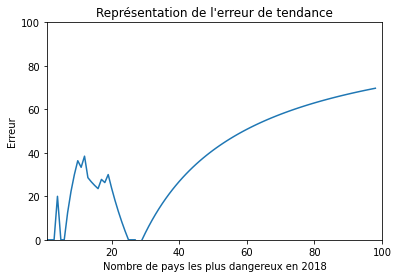

In [61]:
def erreur(i) :
    list_cntry_aim = list(X_test.sort_values(by=['aim'], ascending=False).reset_index().loc[:i, 'country'])
    list_cntry_pred = list(X_test.sort_values(by=['prediction'], ascending=False).reset_index().loc[:i, 'country'])
    L = list(set(list_cntry_aim).intersection(list_cntry_pred)) #les pays en commun avec la réalité
    return (100 - 100*len(L)/i) #l'erreur

plt.title("Représentation de l'erreur de tendance")
plt.plot([erreur(i) for i in range (1,100)])
plt.xlabel('Nombre de pays les plus dangereux en 2018')
plt.ylabel('Erreur')
plt.axis([1, 100, 0, 100])
plt.show()